In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# 1. 백화점 건물번호 리스트 추출
building_info = pd.read_csv('data/building_info.csv')
train_processed = pd.read_csv('data/train.csv')
buildings = building_info[building_info['건물유형'] == '연구소']['건물번호'].tolist()
# 한글 폰트 설정 (Windows 기준)""
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
buildings

[13, 15, 23, 37, 49, 53, 62, 83, 94]

In [3]:
# 이상치 제거 및 추가 피처 생성
outlier_idx = train_processed.index[train_processed['전력소비량(kWh)'] == 0].tolist()
print(f"제거할 이상치 개수: {len(outlier_idx)}")
train_processed.drop(index=outlier_idx, inplace=True)
print(f"남은 행 개수: {train_processed.shape[0]}")

제거할 이상치 개수: 68
남은 행 개수: 203932


In [4]:
import numpy as np
from scipy import stats

def detect_outliers_zscore_only(train_processed, threshold=5):
    """
    Z-score 방법으로만 이상치를 찾아내는 함수
    
    Args:
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        threshold (float): Z-score 임계값 (기본값: 3)
    
    Returns:
        pd.DataFrame: 이상치 데이터
    """
    print(f"�� Z-score 방법으로 이상치 탐지 (임계값: {threshold})")
    print("=" * 60)
    
    outliers_list = []
    
    for building_num in train_processed['건물번호'].unique():
        building_data = train_processed[train_processed['건물번호'] == building_num]['전력소비량(kWh)']
        
        # Z-score 계산
        z_scores = np.abs(stats.zscore(building_data))
        
        # 임계값을 초과하는 이상치 찾기
        building_outliers = train_processed[(train_processed['건물번호'] == building_num) & 
                                          (z_scores > threshold)]
        
        if not building_outliers.empty:
            outliers_list.append(building_outliers)
    
    outliers_df = pd.concat(outliers_list) if outliers_list else pd.DataFrame()
    
    print(f"📊 발견된 이상치: {len(outliers_df)}개")
    
    if not outliers_df.empty:
        print(f"�� 이상치가 있는 건물 수: {outliers_df['건물번호'].nunique()}개")
        print(f"🏢 이상치가 있는 건물 번호: {sorted(outliers_df['건물번호'].unique())}")
        
        # 건물별 이상치 개수
        building_counts = outliers_df['건물번호'].value_counts()
        print(f"\n📈 건물별 이상치 개수:")
        for building_num, count in building_counts.items():
            building_info = pd.read_csv('data/building_info.csv')
            building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
            print(f"   건물 {building_num} ({building_type}): {count}개")
    else:
        print("✅ 이상치가 발견되지 않았습니다.")
    
    return outliers_df

# Z-score 이상치 탐지 실행
outliers_df = detect_outliers_zscore_only(train_processed, threshold=4.5)

# 이상치 상세 분석
if not outliers_df.empty:
    print(f"\n📊 이상치 상세 분석:")
    print("=" * 60)
    
    for building_num in sorted(outliers_df['건물번호'].unique()):
        building_outliers = outliers_df[outliers_df['건물번호'] == building_num]
        building_info = pd.read_csv('data/building_info.csv')
        building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
        
        print(f"\n🏢 건물 {building_num} ({building_type}):")
        print(f"   이상치 개수: {len(building_outliers)}개")
        print(f"   최소 전력소비량: {building_outliers['전력소비량(kWh)'].min():.2f} kWh")
        print(f"   최대 전력소비량: {building_outliers['전력소비량(kWh)'].max():.2f} kWh")
        print(f"   평균 전력소비량: {building_outliers['전력소비량(kWh)'].mean():.2f} kWh")
        
        # 전체 건물 데이터와 비교
        building_all = train_processed[train_processed['건물번호'] == building_num]
        print(f"   전체 데이터 평균: {building_all['전력소비량(kWh)'].mean():.2f} kWh")
        print(f"   이상치 비율: {len(building_outliers)/len(building_all)*100:.2f}%")

�� Z-score 방법으로 이상치 탐지 (임계값: 4.5)
📊 발견된 이상치: 68개
�� 이상치가 있는 건물 수: 11개
🏢 이상치가 있는 건물 번호: [23, 30, 41, 43, 52, 64, 67, 72, 76, 81, 99]

📈 건물별 이상치 개수:
   건물 67 (IDC(전화국)): 48개
   건물 41 (상용): 4개
   건물 43 (IDC(전화국)): 4개
   건물 30 (IDC(전화국)): 2개
   건물 52 (IDC(전화국)): 2개
   건물 76 (상용): 2개
   건물 99 (상용): 2개
   건물 23 (연구소): 1개
   건물 64 (IDC(전화국)): 1개
   건물 72 (공공): 1개
   건물 81 (IDC(전화국)): 1개

📊 이상치 상세 분석:

🏢 건물 23 (연구소):
   이상치 개수: 1개
   최소 전력소비량: 9324.00 kWh
   최대 전력소비량: 9324.00 kWh
   평균 전력소비량: 9324.00 kWh
   전체 데이터 평균: 2339.77 kWh
   이상치 비율: 0.05%

🏢 건물 30 (IDC(전화국)):
   이상치 개수: 2개
   최소 전력소비량: 2444.40 kWh
   최대 전력소비량: 7374.24 kWh
   평균 전력소비량: 4909.32 kWh
   전체 데이터 평균: 9801.04 kWh
   이상치 비율: 0.10%

🏢 건물 41 (상용):
   이상치 개수: 4개
   최소 전력소비량: 246.24 kWh
   최대 전력소비량: 2102.94 kWh
   평균 전력소비량: 1373.76 kWh
   전체 데이터 평균: 2710.89 kWh
   이상치 비율: 0.20%

🏢 건물 43 (IDC(전화국)):
   이상치 개수: 4개
   최소 전력소비량: 834.60 kWh
   최대 전력소비량: 9765.60 kWh
   평균 전력소비량: 5587.50 kWh
   전체 데이터 평균: 14058.80 kWh
   이상치 비율: 0.20%

🏢 

In [5]:
def drop_outliers_safe(train_processed, outliers_df):
    """
    안전한 방법으로 이상치 제거 (모든 컬럼 매칭)
    
    Args:
        train_processed (pd.DataFrame): 전체 학습 데이터
        outliers_df (pd.DataFrame): 이상치 데이터
    
    Returns:
        pd.DataFrame: 이상치가 제거된 데이터
    """
    print(f"🔍 안전한 이상치 제거 시작")
    print(f"   원본 데이터 크기: {len(train_processed)}개")
    print(f"   제거할 이상치 개수: {len(outliers_df)}개")
    
    # 정제된 데이터 초기화
    cleaned_data = train_processed.copy()
    
    # 이상치가 있는 건물들만 처리
    outlier_buildings = outliers_df['건물번호'].unique()
    
    removed_count = 0
    for building_num in outlier_buildings:
        building_outliers = outliers_df[outliers_df['건물번호'] == building_num]
        
        # 해당 건물의 데이터에서 이상치 제거
        building_mask = cleaned_data['건물번호'] == building_num
        
        for _, outlier_row in building_outliers.iterrows():
            # 정확히 일치하는 행 찾기
            match_mask = (
                (cleaned_data['건물번호'] == outlier_row['건물번호']) &
                (cleaned_data['일시'] == outlier_row['일시']) &
                (cleaned_data['전력소비량(kWh)'] == outlier_row['전력소비량(kWh)'])
            )
            
            # 일치하는 행 제거
            cleaned_data = cleaned_data[~match_mask]
            removed_count += match_mask.sum()
    
    print(f"   제거 후 데이터 크기: {len(cleaned_data)}개")
    print(f"   실제 제거된 행 수: {removed_count}개")
    print(f"   제거된 데이터 비율: {removed_count/len(train_processed)*100:.2f}%")
    
    return cleaned_data

# 안전한 이상치 제거 실행
train_processed = drop_outliers_safe(train_processed, outliers_df)

# 결과 확인
print(f"\n📊 안전한 이상치 제거 결과:")
print(f"   정제: {len(train_processed)}개")


🔍 안전한 이상치 제거 시작
   원본 데이터 크기: 203932개
   제거할 이상치 개수: 68개
   제거 후 데이터 크기: 203864개
   실제 제거된 행 수: 68개
   제거된 데이터 비율: 0.03%

📊 안전한 이상치 제거 결과:
   정제: 203864개


In [6]:
building_info['건물유형'].unique()

array(['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)',
       '공공'], dtype=object)

In [7]:
def plot_building_timeseries(building_num, train_processed):
    """
    해당 건물의 전체 데이터를 시계열로 보여주는 그래프
    (주말과 공휴일은 빨간색으로 표시)
    
    Args:
        building_num (int): 분석할 건물 번호
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
    """
    df = train_processed[train_processed['건물번호'] == building_num].copy()
    if df.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return
    
    # 건물 정보 가져오기
    building_info = pd.read_csv('data/building_info.csv')
    building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
    
    df = df.sort_values('일시')
    df['일시'] = pd.to_datetime(df['일시'])
    df.set_index('일시', inplace=True)
    
    # 주말과 공휴일 설정
    holi_weekday = ['2024-06-06', '2024-08-15']
    
    # 주말과 공휴일 여부 판단
    df['day_of_week'] = df.index.dayofweek
    df['date_str'] = df.index.strftime('%Y-%m-%d')
    df['is_holiday'] = ((df['day_of_week'] >= 5) | (df['date_str'].isin(holi_weekday))).astype(int)
    
    # 평일과 휴일 데이터 분리
    weekday_data = df[df['is_holiday'] == 0]
    holiday_data = df[df['is_holiday'] == 1]
    
    plt.figure(figsize=(18, 8))
    
    # 평일 데이터 (파란색)
    if not weekday_data.empty:
        plt.plot(weekday_data.index, weekday_data['전력소비량(kWh)'], 
                linewidth=0.8, alpha=0.8, color='blue', label='평일')
    
    # 휴일 데이터 (빨간색)
    if not holiday_data.empty:
        plt.plot(holiday_data.index, holiday_data['전력소비량(kWh)'], 
                linewidth=0.8, alpha=0.8, color='red', label='주말/공휴일')
    
    plt.title(f'건물 {building_num} ({building_type}) - 전체 전력소비량 시계열')
    plt.xlabel('일시')
    plt.ylabel('전력소비량 (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 주요 눈금
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

def plot_hourly_usage_pattern(building_num, train_processed):
    """
    해당 건물의 시간대별 사용량 분석을 위한 그래프
    
    Args:
        building_num (int): 분석할 건물 번호
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
    """
    df = train_processed[train_processed['건물번호'] == building_num].copy()
    if df.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return
    
    # 건물 정보 가져오기
    building_info = pd.read_csv('data/building_info.csv')
    building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
    
    df['일시'] = pd.to_datetime(df['일시'])
    df['시간'] = df['일시'].dt.hour
    
    # 시간대별 평균 전력소비량 계산
    hourly_usage = df.groupby('시간')['전력소비량(kWh)'].mean()
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # 1. 시간대별 평균 사용량
    ax1.plot(hourly_usage.index, hourly_usage.values, marker='o', linewidth=2, markersize=6)
    ax1.set_title(f'건물 {building_num} ({building_type}) - 시간대별 평균 전력소비량')
    ax1.set_xlabel('시간')
    ax1.set_ylabel('평균 전력소비량 (kWh)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24))
    
    # 2. 히트맵 (요일별, 시간대별)
    df['요일'] = df['일시'].dt.dayofweek
    df['요일명'] = df['일시'].dt.day_name()
    
    # 요일별, 시간대별 평균 사용량 계산
    pivot_data = df.pivot_table(
        values='전력소비량(kWh)', 
        index='요일명', 
        columns='시간', 
        aggfunc='mean'
    )
    
    # 요일 순서 정렬
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_data = pivot_data.reindex(day_order)
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title(f'건물 {building_num} ({building_type}) - 요일별, 시간대별 평균 전력소비량')
    ax2.set_xlabel('시간')
    ax2.set_ylabel('요일')
    
    plt.tight_layout()
    plt.show()

In [22]:
buildings = building_info[building_info['건물유형'] == '연구소']['건물번호'].tolist()

In [23]:
buildings

[13, 15, 23, 37, 49, 53, 62, 83, 94]

In [24]:
n = 0

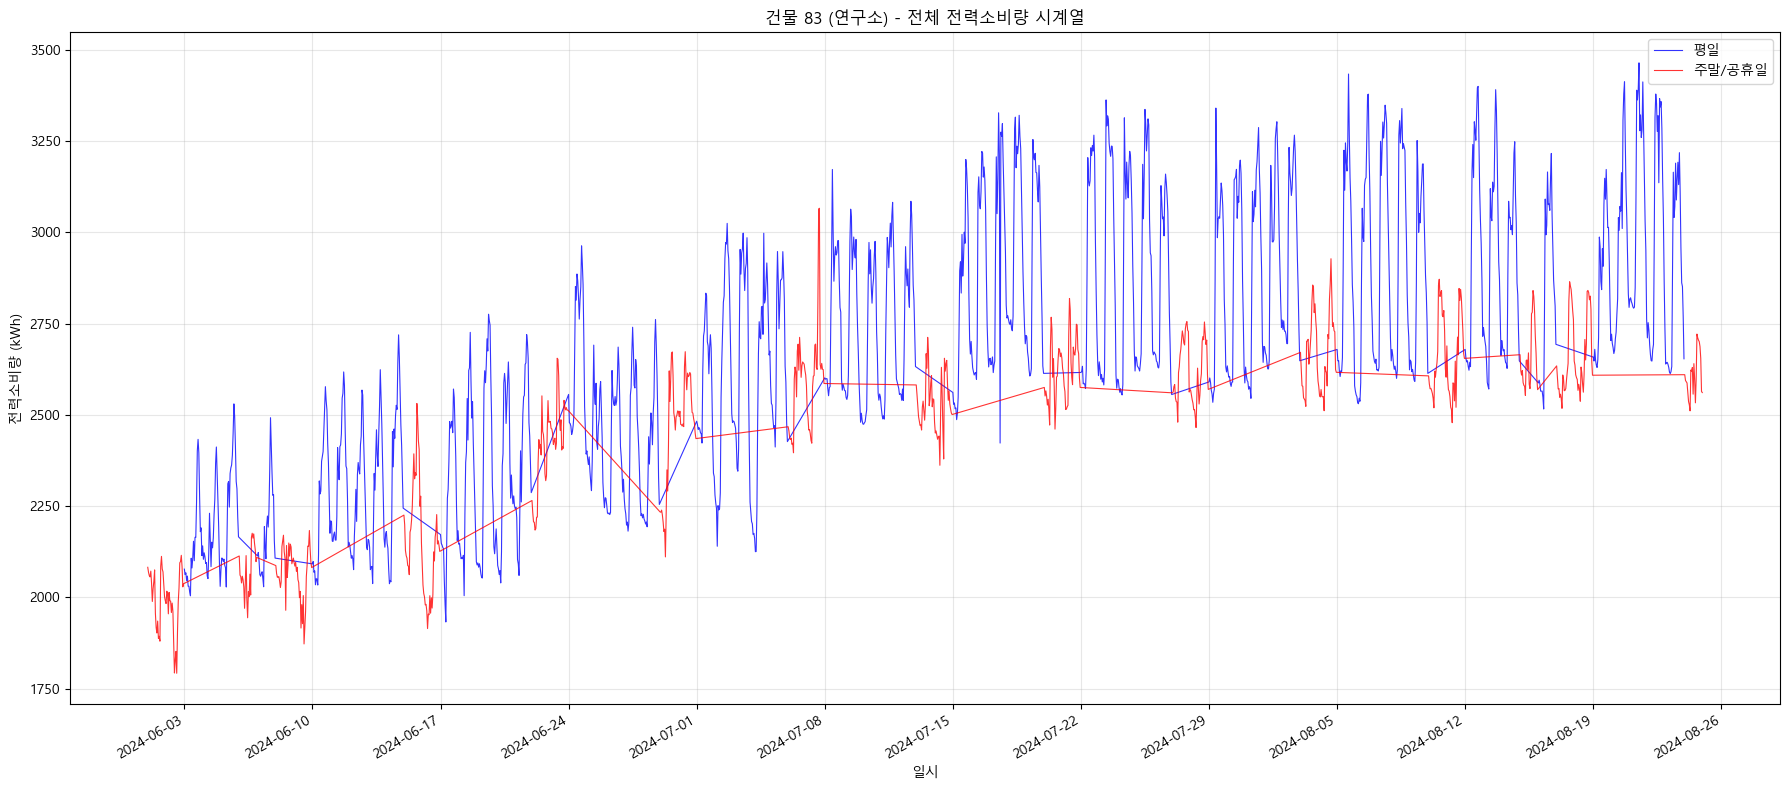

In [32]:
plot_building_timeseries(buildings[n], train_processed)
#plot_hourly_usage_pattern(n, train_processed)
n +=1

In [ ]:
def plot_building_timeseries(building_num, train_processed, threshold=0.7):
    """
    해당 건물의 전체 데이터를 시계열로 보여주는 그래프
    (주말과 공휴일은 빨간색으로 표시)
    주말 전력 사용량이 평일 평균의 threshold보다 낮으면 "주말에 쉬는 곳" 출력
    
    Args:
        building_num (int): 분석할 건물 번호
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        threshold (float): 주말 사용량이 평일 평균의 몇 % 이하일 때 쉬는 곳으로 판단할지 (기본값: 0.7)
    """
    df = train_processed[train_processed['건물번호'] == building_num].copy()
    if df.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return
    
    # 건물 정보 가져오기
    building_info = pd.read_csv('data/building_info.csv')
    building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
    
    df = df.sort_values('일시')
    df['일시'] = pd.to_datetime(df['일시'])
    df.set_index('일시', inplace=True)
    
    # 주말과 공휴일 설정
    holi_weekday = ['2024-06-06', '2024-08-15']
    
    # 주말과 공휴일 여부 판단
    df['day_of_week'] = df.index.dayofweek
    df['date_str'] = df.index.strftime('%Y-%m-%d')
    df['is_holiday'] = ((df['day_of_week'] >= 5) | (df['date_str'].isin(holi_weekday))).astype(int)
    
    # 평일과 휴일 데이터 분리
    weekday_data = df[df['is_holiday'] == 0]
    holiday_data = df[df['is_holiday'] == 1]
    
    # 주말 쉬는 곳 판단 로직 추가
    if not weekday_data.empty and not holiday_data.empty:
        weekday_avg = weekday_data['전력소비량(kWh)'].mean()
        holiday_avg = holiday_data['전력소비량(kWh)'].mean()
        
        if weekday_avg > 0:  # 0으로 나누기 방지
            holiday_ratio = holiday_avg / weekday_avg
            
            print(f"📊 건물 {building_num} ({building_type}) 분석:")
            print(f"   평일 평균 전력소비량: {weekday_avg:.2f} kWh")
            print(f"   주말/공휴일 평균 전력소비량: {holiday_avg:.2f} kWh")
            print(f"   주말/평일 비율: {holiday_ratio:.3f}")
            
            if holiday_ratio < threshold:
                print(f"✅ 주말에 쉬는 곳입니다! (비율: {holiday_ratio:.3f} < {threshold})")
            else:
                print(f"❌ 주말에도 운영하는 곳입니다. (비율: {holiday_ratio:.3f} >= {threshold})")
            print()
    
    plt.figure(figsize=(18, 8))
    
    # 평일 데이터 (파란색)
    if not weekday_data.empty:
        plt.plot(weekday_data.index, weekday_data['전력소비량(kWh)'], 
                linewidth=0.8, alpha=0.8, color='blue', label='평일')
    
    # 휴일 데이터 (빨간색)
    if not holiday_data.empty:
        plt.plot(holiday_data.index, holiday_data['전력소비량(kWh)'], 
                linewidth=0.8, alpha=0.8, color='red', label='주말/공휴일')
    
    plt.title(f'건물 {building_num} ({building_type}) - 전체 전력소비량 시계열')
    plt.xlabel('일시')
    plt.ylabel('전력소비량 (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 주요 눈금
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [ ]:
def find_holiday_closed_buildings(train_processed, threshold=0.85):
    """
    휴일에 쉬는 건물들을 찾아서 리스트로 반환
    
    Args:
        train_processed (pd.DataFrame): 전처리된 전체 학습 데이터
        threshold (float): 주말 사용량이 평일 평균의 몇 % 이하일 때 쉬는 곳으로 판단할지 (기본값: 0.85)
    
    Returns:
        list: 휴일에 쉬는 건물 번호 리스트
    """
    holiday_closed_buildings = []
    
    # 모든 건물 번호 가져오기
    building_info = pd.read_csv('data/building_info.csv')
    all_buildings = building_info['건물번호'].unique()
    
    print(f"🔍 threshold={threshold}로 휴일에 쉬는 건물들을 찾는 중...")
    print("=" * 60)
    
    for building_num in all_buildings:
        df = train_processed[train_processed['건물번호'] == building_num].copy()
        
        if df.empty:
            continue
            
        # 건물 정보 가져오기
        building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
        
        df['일시'] = pd.to_datetime(df['일시'])
        df.set_index('일시', inplace=True)
        
        # 주말과 공휴일 설정
        holi_weekday = ['2024-06-06', '2024-08-15']
        
        # 주말과 공휴일 여부 판단
        df['day_of_week'] = df.index.dayofweek
        df['date_str'] = df.index.strftime('%Y-%m-%d')
        df['is_holiday'] = ((df['day_of_week'] >= 5) | (df['date_str'].isin(holi_weekday))).astype(int)
        
        # 평일과 휴일 데이터 분리
        weekday_data = df[df['is_holiday'] == 0]
        holiday_data = df[df['is_holiday'] == 1]
        
        # 주말 쉬는 곳 판단
        if not weekday_data.empty and not holiday_data.empty:
            weekday_avg = weekday_data['전력소비량(kWh)'].mean()
            holiday_avg = holiday_data['전력소비량(kWh)'].mean()
            
            if weekday_avg > 0:  # 0으로 나누기 방지
                holiday_ratio = holiday_avg / weekday_avg
                
                if holiday_ratio < threshold:
                    holiday_closed_buildings.append(building_num)
                    print(f"✅ 건물 {building_num} ({building_type}): 주말에 쉬는 곳 (비율: {holiday_ratio:.3f})")
                else:
                    print(f"❌ 건물 {building_num} ({building_type}): 주말에도 운영 (비율: {holiday_ratio:.3f})")
    
    print("=" * 60)
    print(f"�� 결과: 총 {len(holiday_closed_buildings)}개 건물이 휴일에 쉬는 곳으로 판단됨")
    print(f"휴일에 쉬는 건물 번호: {holiday_closed_buildings}")
    
    return holiday_closed_buildings

# 휴일에 쉬는 건물 리스트 찾기
holiday_closed_buildings = find_holiday_closed_buildings(train_processed, threshold=0.85)

# 결과를 변수에 저장 (나중에 사용할 수 있도록)
print(f"\n💾 holiday_closed_buildings 변수에 {len(holiday_closed_buildings)}개 건물 번호가 저장되었습니다.")

In [ ]:
n=7

In [ ]:
# 기본 threshold (0.7) 사용
plot_building_timeseries(holiday_closed_buildings[n], train_processed, threshold=0.85)
n+=1

In [ ]:
buildings

In [ ]:
plot_building_timeseries(55, train_processed, threshold=0.85)

In [ ]:
def compare_building_lists(buildings, holiday_closed_buildings):
    """
    buildings 리스트와 holiday_closed_buildings를 비교하여 
    buildings에서 휴일에 쉬는 건물이 몇 개인지 확인
    
    Args:
        buildings (list): 비교할 건물 번호 리스트
        holiday_closed_buildings (list): 휴일에 쉬는 건물 번호 리스트
    
    Returns:
        tuple: (총 개수, 휴일에 쉬는 건물 개수, 휴일에 쉬는 건물 리스트)
    """
    # buildings에서 휴일에 쉬는 건물 찾기
    closed_in_buildings = [b for b in buildings if b in holiday_closed_buildings]
    
    total_count = len(buildings)
    closed_count = len(closed_in_buildings)
    
    print(f"📊 buildings 리스트 분석 결과:")
    print(f"   총 건물 수: {total_count}개")
    print(f"   휴일에 쉬는 건물 수: {closed_count}개")
    print(f"   비율: {closed_count/total_count*100:.1f}%")
    
    if closed_count > 0:
        print(f"   휴일에 쉬는 건물 번호: {closed_in_buildings}")
    else:
        print("   휴일에 쉬는 건물이 없습니다.")
    
    return total_count, closed_count, closed_in_buildings

In [ ]:
buliding_list = building_info['건물유형'].unique()

In [ ]:
buliding_list

In [ ]:
buildings = building_info[building_info['건물유형'] == buliding_list[9]]['건물번호'].tolist()

In [ ]:
buildings

In [ ]:
# buildings와 holiday_closed_buildings 비교
total, closed, closed_list = compare_building_lists(buildings, holiday_closed_buildings)

# 추가 분석: 건물 유형별로도 확인
building_info = pd.read_csv('data/building_info.csv')

print(f"\n🏢 buildings 리스트의 건물 유형별 분석:")
for building_num in buildings:
    building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
    is_closed = building_num in holiday_closed_buildings
    status = "✅ 휴일에 쉬는 곳" if is_closed else "❌ 주말에도 운영"
    print(f"   건물 {building_num} ({building_type}): {status}")

In [ ]:
n=0
temp = buildings[n]

In [ ]:

plot_building_timeseries(temp, train_processed)
n +=1 
temp = buildings[n]

In [ ]:
def plot_building_outliers(building_num, train_processed, outliers_df):
    """
    개별 건물의 이상치 시각화
    
    Args:
        building_num (int): 건물 번호
        train_processed (pd.DataFrame): 전체 데이터
        outliers_df (pd.DataFrame): 이상치 데이터
    """
    df = train_processed[train_processed['건물번호'] == building_num].copy()
    if df.empty:
        print(f"❌ 건물 {building_num}의 데이터가 없습니다.")
        return
    
    building_info = pd.read_csv('data/building_info.csv')
    building_type = building_info[building_info['건물번호'] == building_num]['건물유형'].iloc[0]
    
    df = df.sort_values('일시')
    df['일시'] = pd.to_datetime(df['일시'])
    df.set_index('일시', inplace=True)
    
    # 해당 건물의 이상치 데이터
    building_outliers = outliers_df[outliers_df['건물번호'] == building_num].copy()
    if not building_outliers.empty:
        building_outliers['일시'] = pd.to_datetime(building_outliers['일시'])
        building_outliers.set_index('일시', inplace=True)
    
    # 정상 데이터와 이상치 분리
    normal_data = df.drop(building_outliers.index, errors='ignore')
    
    plt.figure(figsize=(18, 8))
    
    # 정상 데이터 (파란색)
    plt.plot(normal_data.index, normal_data['전력소비량(kWh)'], 
            linewidth=0.8, alpha=0.8, color='blue', label='정상 데이터')
    
    # 이상치 (빨간색)
    if not building_outliers.empty:
        plt.scatter(building_outliers.index, building_outliers['전력소비량(kWh)'], 
                   color='red', s=20, alpha=0.8, label='이상치')
    
    plt.title(f'건물 {building_num} ({building_type}) - 이상치 시각화')
    plt.xlabel('일시')
    plt.ylabel('전력소비량 (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# 사용 예시:
# plot_building_outliers(8, train_processed, outliers_df)

In [ ]:
outer_list=outliers_df['건물번호'].unique()
outer_list

In [ ]:
n= 67
plot_building_outliers(n,train_processed, outliers_df)
plot_building_timeseries(n, train_processed)